<center>
<img src="Stone_Soup_Icon_Final_small.png">
<h1>Stone Soup AIS Demo</h1>
Demonstrating the Stone Soup capabilities for processing AIS data - ingesting from JSON text files from www.aishub.net and filtering tracks by reported MMSI.
</center>

Initially, we'll set up some initial import and a plotting method which we'll use later.

In [1]:
#General imports and plotting
import datetime
import numpy as np

# Plotting
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-colorblind')

def plot_data(groundtruth_paths, detections, tracks):
    from stonesoup.types.detection import Clutter
    data = np.array([detection.state_vector for detection in detections if not isinstance(detection, Clutter)])
    if data.any():
        plt.plot(data[:,0], data[:, 1], linestyle='', marker='o')

    data = np.array([detection.state_vector for detection in detections if isinstance(detection, Clutter)])
    if data.any():
        plt.plot(data[:,0], data[:, 1], linestyle='', marker='2')

    for path in groundtruth_paths:  
        data = np.array([state.state_vector for state in path])
        plt.plot(data[:, 0], data[:, 2], linestyle=':', marker='')

    from stonesoup.types.prediction import Prediction
    for track in tracks:
        if len([state for state in track.states if not isinstance(state, Prediction)]) < 2:
            continue  # Don't plot tracks with only one detection associated; probably clutter
        data = np.array([state.state_vector for state in track.states])
        plt.plot(data[:, 0], data[:, 2], linestyle='-', marker='.')
        if hasattr(track.state, 'particles'):
            data = np.array([particle.state_vector for state in track.states for particle in state.particles])
            plt.plot(data[:,0], data[:,2], linestyle='', marker=".", markersize=1, alpha=0.25)

    plt.xlabel("$x$")        
    plt.ylabel("$y$")
    custom_legend = [
        matplotlib.lines.Line2D([0], [0], color='0', linestyle='', marker='o'),
        matplotlib.lines.Line2D([0], [0], color='0', linestyle='', marker='2'),
        matplotlib.lines.Line2D([0], [0], color='0', linestyle=':', marker=''),
        matplotlib.lines.Line2D([0], [0], color='0', linestyle='-', marker='.'),
        matplotlib.lines.Line2D([0], [0], color='0', linestyle='', marker='.', markersize=1),
    ]
    plt.legend(custom_legend,
               ['Detections', 'Clutter', 'Path', 'Track', 'Particles'])

Generating Data
----------------
First we'll create some models, which will be used by the tracker.

This will include a 2D-position constant velocity transition model ($x$, $\dot{x}$, $y$ and $\dot{y}$) generated by combining two 1D models (this allows multiple models to be mixed and generation of *n*-dimension models).

In [2]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel((ConstantVelocity(1e-6), ConstantVelocity(1e-6)))

And a measurement model, which will map the position based detections ($x$ and $y$) to the position in the state.

In [3]:
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(ndim_state=4, mapping=[0, 2], noise_covar=np.diag([1e-3, 1e-3]))

Next we'll create a file reader that will read the AIS data from a JSON file.

In [4]:
from stonesoup.reader.aishub import JSON_AISDetectionReader

detections_source = JSON_AISDetectionReader(path='sample_MMSI_tracks.json')

Building Kalman tracker components
------------------------------------

With the detection data ready, we'll now build a Kalman tracker. For this we will need a Kalman predictor, which will utilise the *transition model* created earlier.

In [5]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

And a Kalman updater, utilising the *measurement model* created earlier.

In [6]:
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

We will also need a data associator to link detections to the "correct" track for the update step: in this case a Nearest Neighbour is fine for this demo. The data associator requires a hypothesiser which calculates some form of score/probability of each track being associated to each detection: in this case using a Mahalanobis distance from track prediction to the detection (which will also generate missed detection hypothesis). We will use a wrapper around the Mahalanobis distance hypothesiser; this wrapper will filter AIS detections by MMSI (self-reported unique ship identifier) so that detections are only associated with tracks with the same MMSI.

In [7]:
from stonesoup.hypothesiser.distance import MahalanobisDistanceHypothesiser
from stonesoup.hypothesiser.filtered import FilteredDetectionsHypothesiser
hypothesiser = MahalanobisDistanceHypothesiser(predictor, updater, missed_distance=0.2)
hypothesiser_wrapper = FilteredDetectionsHypothesiser(hypothesiser, "MMSI", match_missing=True)

In [8]:
from stonesoup.dataassociator.neighbour import NearestNeighbour
data_associator = NearestNeighbour(hypothesiser_wrapper)

And finally a initiator to generate tracks from unassociated detections, in this case a single point initiator generating a track for every unassociated detection.

In [9]:
from stonesoup.initiator.simple import SinglePointInitiator
from stonesoup.types.state import GaussianState
initiator = SinglePointInitiator(
    GaussianState(np.array([[0], [0], [0], [0]]), np.diag([50, 0.5, 50, 0.5])),
    measurement_model=measurement_model)

And a deleter to remove tracks, for this demo simply based on large covariance threshold.

In [10]:
from stonesoup.deleter.simple import CovarianceBasedDeleter
deleter = CovarianceBasedDeleter(covar_trace_thresh=1E5)

Running the Kalman tracker
---------------------------
With all the components in place, we'll now construct the tracker with a multi target tracker.

In [11]:
from stonesoup.tracker.simple import MultiTargetTracker
tracker = MultiTargetTracker(
    initiator=initiator,
    deleter=deleter,
    detector=detections_source,
    data_associator=data_associator,
    updater=updater,
)

In [12]:
tracks = set()
detections = set()
groundtruth_paths = set()
                
for time, ctracks in tracker.tracks_gen():
    tracks.update(ctracks)
    detections |= tracker.detector.detections
    groundtruth_paths = groundtruth_paths

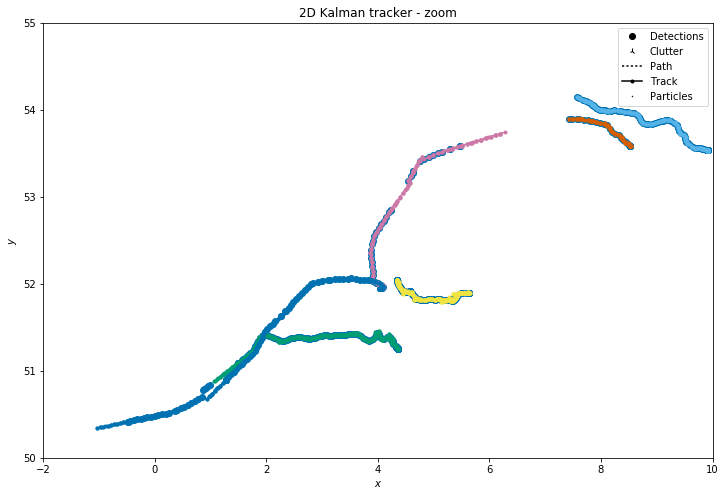

In [15]:
plot_data(groundtruth_paths, detections, tracks);plt.title("2D Kalman tracker - zoom");
plt.xlim(-2, 10);
plt.ylim(50, 55);

Note: For reference, the lower left corner of this graph is off the south coast of England, and the two tracks in the upper right corner are on the Elbe and Weser river in northwest Germany.

Note: Note how several of the tracks are predicted over extended periods of the ships falling out of contact, and the tracks re-associate with the ship detections when they come back into contact.

Note: Colours are random to help differentiate overlapping data.